In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from torch.autograd import Function
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
%cd 'drive/My Drive/ACV Project/'

/content/drive/.shortcut-targets-by-id/1-uBPm49Eo3uaCU1aA2S0UwaL0_iMXQKS/ACV Project


In [5]:
dim = 64
X = np.load(f'./Dataset-{dim}/TR-Image.npy')
y = np.load(f'./Dataset-{dim}/TR-Mask.npy')

X_test = np.load(f'./Dataset-{dim}/TE-Image.npy')
y_test = np.load(f'./Dataset-{dim}/TE-Mask.npy')

In [6]:
print(y.max(), y.min(), np.unique(y))

1 0 [0 1]


In [7]:
print(X.shape, X.dtype, X.max(), X.min())

(10553, 64, 64, 3) uint8 255 0


In [8]:
num_train = int(len(X) * 0.8)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]

X_train, X_val = X[ : num_train], X[num_train : ]
y_train, y_val = y[ : num_train], y[num_train : ]

In [9]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(8442, 64, 64, 3) (2111, 64, 64, 3)
(8442, 64, 64) (2111, 64, 64)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, lab = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img).type(torch.FloatTensor)
        
        lab = torch.from_numpy(lab).type(torch.LongTensor)
        return (img, lab)

In [11]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
    ]
)

In [12]:
train_set = CustomDataset(X_train, y_train, transform=transform)
val_set = CustomDataset(X_val, y_val, transform=transform)
test_set = CustomDataset(X_test, y_test, transform=transform)

In [13]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [14]:
itr = iter(train_loader)
img, lab = next(itr)

print(img.size(), lab.size())
print(img.type(), lab.type())

torch.Size([32, 3, 64, 64]) torch.Size([32, 64, 64])
torch.FloatTensor torch.LongTensor


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 64x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop1 = nn.Dropout()

        #16x16
        self.conv5 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop2 = nn.Dropout()

        #8x8
        self.conv7 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn8 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop3 = nn.Dropout()

        #4x4
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn9 = nn.BatchNorm2d(128)

        #8x8
        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn10 = nn.BatchNorm2d(128)
        #16x16
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.bn11 = nn.BatchNorm2d(64)
        #32x32
        self.upconv4 = nn.ConvTranspose2d(64, 2, kernel_size = 2, stride = 2)
        #64x64

        self.upscore1 = nn.Upsample(scale_factor=16,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore4 = nn.Upsample(scale_factor=2,mode='bilinear')

        self.outconv1 = nn.Conv2d(128,2,3,padding=1)
        self.outconv2 = nn.Conv2d(128,2,3,padding=1)
        self.outconv3 = nn.Conv2d(128,2,3,padding=1)
        self.outconv4 = nn.Conv2d(64,2,3,padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x1 = self.pool1(x)
        

        x = F.relu(self.bn3(self.conv3(x1)))
        x = F.relu(self.bn4(self.conv4(x)))
        x2 = self.pool2(x)
        x = self.drop1(x2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x3 = self.pool3(x)

        x = F.relu(self.bn7(self.conv7(x3)))
        x = F.relu(self.bn8(self.conv8(x)))
        x4 = self.pool4(x)

        x5 = F.relu(self.bn9(self.upconv1(self.drop3(x4))))
        x6 = F.relu(self.bn10(self.upconv2(self.drop2(x5 + x3))))
        x7 = F.relu(self.bn11(self.upconv3(x6 + x2)))
        x8 = self.upconv4(x7 + x1)

        return self.upscore1(self.outconv1(x4)), self.upscore2(self.outconv2(x5)), self.upscore3(self.outconv3(x6)), self.upscore4(self.outconv4(x7)), x8

In [17]:
class RefineNet(nn.Module):

    def __init__(self):
        super(RefineNet, self).__init__()

        # 64x64
        self.conv1 = nn.Conv2d(2, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #32x32
        self.conv2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #16x16
        self.conv3 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #8x8
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn4 = nn.BatchNorm2d(128)

        #16x16
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.bn5 = nn.BatchNorm2d(64)
        #32x32
        self.upconv3 = nn.ConvTranspose2d(64, 2, kernel_size = 2, stride = 2)
        #64x64

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.upconv1(x)))
        x = F.relu(self.bn5(self.upconv2(x)))
        x = self.upconv3(x)

        return x

In [18]:
model = Net().to(device)
refine_model = RefineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
refine_optimizer = optim.Adam(refine_model.parameters())

In [19]:
def IoULoss(predicted, ground_truth):

    intersect = (predicted * ground_truth).sum((1, 2))
    union = (predicted + ground_truth).clamp(0, 1).sum((1, 2))

    return (1 - (intersect / union)).mean()

In [20]:
def train(model, refine_model, train_loader):
    model.train()
    refine_model.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        refine_optimizer.zero_grad()

        outputs1, outputs2, outputs3, outputs4, outputs5 = model(inputs)

        loss1 = criterion(outputs1, labels) + IoULoss(outputs1.max(dim=1)[1], labels)
        loss2 = criterion(outputs2, labels) + IoULoss(outputs2.max(dim=1)[1], labels)
        loss3 = criterion(outputs3, labels) + IoULoss(outputs3.max(dim=1)[1], labels)
        loss4 = criterion(outputs4, labels) + IoULoss(outputs4.max(dim=1)[1], labels)
        loss5 = criterion(outputs5, labels) + IoULoss(outputs5.max(dim=1)[1], labels)
        
        outputs6 = refine_model(outputs5)
        
        loss6 = criterion(outputs6, labels) + IoULoss(outputs6.max(dim=1)[1], labels)
        
        loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6

        running_loss += loss.item()
        loss.backward()
        refine_optimizer.step()
        optimizer.step()

        if i % 50 == 49:
            print(f'Iteration {i + 1:5} | { (running_loss / 50):.5f}')
            running_loss = 0.0


In [21]:
def accuracy(model, refine_model, dataloader):
    model.eval()
    refine_model.eval()

    correct = 0
    total = 0
    iters = 0
    running_loss = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,_,outputs = model(images)
            outputs = refine_model(outputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += (labels.size(0) * labels.size(1) * labels.size(2))
            correct += (predicted == labels).sum().item()
            iters += 1

    print('Accuracy of the network on the images: %.3f %%' % (100 * correct / total))
    return (running_loss / iters), (100 * correct / total)

In [22]:
def mIoU(model, refine_model, dataloader, n_classes):
    model.eval()
    refine_model.eval()

    intersection = [0 for i in range(n_classes)]
    union = [0 for i in range(n_classes)]

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,_,outputs = model(images)
            outputs = refine_model(outputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(n_classes):
                intersect = torch.mul(predicted==i, labels==i).sum().item()
                uni = torch.add(predicted==i, labels==i).sum().item()
                intersection[i] += intersect
                union[i] += uni

    iou = [0 for i in range(n_classes)]
    for i in range(n_classes):
        iou[i] = intersection[i] / union[i]
    
    return sum(iou) / len(iou)

In [23]:
# start = 0
# epochs = 100
# train_acc = []
# train_loss = []
# val_acc = []
# val_loss = []

# for epoch in range(start, start + epochs):
#     print(f'Epoch {epoch + 1} started')
#     train(model, refine_model, train_loader)

#     print('IOU Train', mIoU(model, refine_model, train_loader, 2))
#     print('IOU val', mIoU(model, refine_model, val_loader, 2))

#     loss, acc = accuracy(model, refine_model, train_loader)
#     train_acc.append(acc)
#     train_loss.append(loss)
#     loss, acc = accuracy(model, refine_model, val_loader)
#     val_acc.append(acc)
#     val_loss.append(loss)

#     PATH = './CustomNet-64-v5-refinenet-extra-depth/' + str(epoch + 1)
#     torch.save(model, PATH)

#     PATH += '-checkpoint'
#     torch.save({
#         'epoch': epoch+1,
#         'model-state-dict': model.state_dict(),
#         'refine_model-state-dict': refine_model.state_dict(),
#         'refinemodel-state-dict': refine_model.state_dict(),
#         'train_acc': train_acc,
#         'train_loss': train_loss,
#         'val_acc': val_acc,
#         'val_loss': val_loss
#     }, PATH)

In [36]:
PATH = './CustomNet-64-v5-refinenet-extra-depth/100-checkpoint'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model-state-dict'])
refine_model.load_state_dict(checkpoint['refine_model-state-dict'])

<All keys matched successfully>

In [33]:
np.argmax(np.array(checkpoint['val_acc'])), np.max(np.array(checkpoint['val_acc']))

(78, 94.47448817207484)

In [34]:
accuracy(model, refine_model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Accuracy of the network on the images: 90.843 %


(0.34531418314784956, 90.84271273068589)

In [35]:
mIoU(model, refine_model, test_loader, 2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7199452474441845

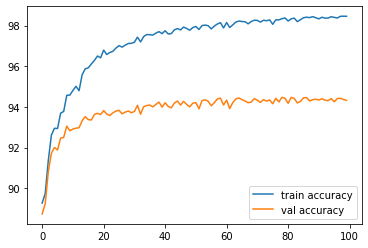

In [37]:
train_acc = checkpoint['train_acc']
train_loss = checkpoint['train_loss']
val_acc = checkpoint['val_acc']
val_loss = checkpoint['val_loss']

plt.plot(list(range(checkpoint['epoch'])), train_acc)
plt.plot(list(range(checkpoint['epoch'])), val_acc)
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
plt.show()

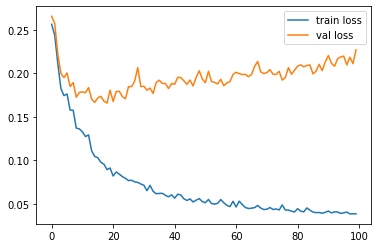

In [38]:
plt.plot(list(range(checkpoint['epoch'])), train_loss)
plt.plot(list(range(checkpoint['epoch'])), val_loss)
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [39]:
colors = [
    np.array([0,0,0], dtype=np.uint8),
    np.array([255,255,255], dtype=np.uint8),
]

In [40]:
itr = iter(test_loader)

torch.Size([3, 64, 64]) | torch.Size([64, 64]) | torch.Size([64, 64])
(64, 64, 3)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


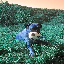

In [60]:
model.eval()
img, lab = itr.next()
_,_,_,_,outputs = model(img.to(device))
outputs = refine_model(outputs)
_,predicted = torch.max(outputs, 1)

input, lab, pred = img[0], lab[0], predicted[0].cpu().detach()
print(f'{input.size()} | {lab.size()} | {pred.size()}')

img_size = input.shape[-1]
input_img = np.zeros((img_size, img_size, 3))
input_img[:, :, 0] = input[0]
input_img[:, :, 1] = input[1]
input_img[:, :, 2] = input[2]

input_img = (255 * input_img)
print(input_img.shape)
input_img = Image.fromarray(input_img.astype('uint8'), mode='RGB')
ground_truth = np.zeros((img_size, img_size, 3), dtype=np.uint8)
predicted = np.zeros((img_size, img_size, 3), dtype=np.uint8)

for i in range(img_size):
    for j in range(img_size):
        ground_truth[i][j] = colors[lab[i][j]]
        predicted[i][j] = colors[pred[i][j]]

ground_truth = Image.fromarray(ground_truth).convert('RGB')
predicted = Image.fromarray(predicted).convert('RGB')

display(input_img)

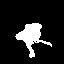

In [61]:
display(ground_truth)

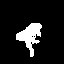

In [62]:
display(predicted)

In [ ]:
def get_image_predictions(img_path, model, refine_model):
    colors = [
        np.array([0,0,0], dtype=np.uint8),
        np.array([255,255,255], dtype=np.uint8),
    ]

    model.eval()
    refine_model.eval()

    img = Image.open(img_path).resize((256, 256))
    # display(img)
    img = np.array(img).transpose(2, 0, 1)

    img = torch.from_numpy(img.astype(np.float32)/255).to(device).unsqueeze(0)
    _,_,_,_,output = model(img)
    output = refine_model(output)
    _,pred = torch.max(output, 1)
    pred = pred[0].cpu().detach()

    img_size = pred.size(0)
    predicted = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    for i in range(img_size):
        for j in range(img_size):
            predicted[i][j] = colors[pred[i][j]]
    
    # predicted = Image.fromarray(predicted).convert('RGB')

    return predicted

import cv2

def get_bb(img):
	a = np.where(img != 0)
	ans = (np.min(a[1]), np.min(a[0]), np.max(a[1]), np.max(a[0]))
	return ans

def draw_bb(img, bb):
    x0, y0, x1, y1 = bb
    cv2.rectangle(img, (x0, y0), (x1, y1), (255, 0, 0), 1)
    display(Image.fromarray(img, mode="RGB"))

def process_mask(mask):
    blurred_mask = cv2.blur(mask, (16, 16))
    ret, th = cv2.threshold(blurred_mask, 200, 255, cv2.THRESH_BINARY)
    kernel = np.ones((4, 4))
    eroded = cv2.erode(th, kernel=kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel=kernel, iterations=8)
    final_mask = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
    return final_mask

def dist(x, y, c_x, c_y):
    return np.sqrt((x - c_x)**2 + (y - c_y)**2)


def spatial_weighing_exponential(mask):
    # return mask
    # display(Image.fromarray(mask))
    c_x, c_y = mask.shape[0] // 2, mask.shape[1] // 2
    ks = [96, 112, 128, 144]
    weights_arr = []
    dists = np.array([[dist(i, j, c_x, c_y) for j in range(mask.shape[1])] for i in range(mask.shape[0])])
    for k in ks:    
        weights = np.exp(-dists / k)
        masked = weights * mask
        weights_arr += [masked]

    weights = sum(weights_arr) / len(weights_arr)
    ret, th = cv2.threshold(weights, 128, 255, cv2.THRESH_BINARY)
    return th

def spatial_weighing_linear(mask):
    # display(Image.fromarray(mask))
    c_x, c_y = mask.shape[0] // 2, mask.shape[1] // 2
    dists = np.array([[dist(i, j, c_x, c_y) for j in range(mask.shape[1])] for i in range(mask.shape[0])])
    
    low = 0
    up = 1

    mx = dist(0, 0, c_x, c_y)
    dists /= mx
    weights = up - dists * (up - low)
    
    masked = weights * mask
    masked = masked.astype('uint8')
    ret, th = cv2.threshold(masked, 128, 255, cv2.THRESH_BINARY)
    # display(Image.fromarray(th))
    
    return th

def jpg_to_png(img, mask, out_path):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    img[:, :, 3] *= mask
    display(Image.fromarray(img, mode='RGBA'))
    cv2.imwrite(out_path, img)

def my_grab_cut(img, mask, bb, out_path):
    bgdModel = np.zeros((1, 65),np.float64)
    fgdModel = np.zeros((1, 65),np.float64)

    final_mask, bgdModel, fgdModel = cv2.grabCut(img, mask, bb, bgdModel, fgdModel, 500, cv2.GC_INIT_WITH_RECT)
    mask = np.where((final_mask == 2)|(final_mask == 0),0,1).astype('uint8')
        
    jpg_to_png(img, mask, out_path)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


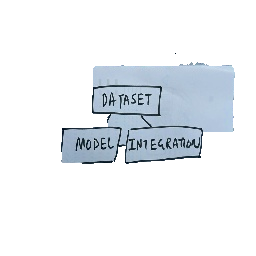

In [ ]:
for i in ([21]):
    path = f'./test_images/{i}.jpg'
    out_path = f'./Outputs/grab_cut/exp_op_{i}.png'

    prediction = get_image_predictions(path, model, refine_model)
    processed = process_mask(prediction)
    weighted = spatial_weighing_exponential(processed)

    bb = get_bb(weighted)
    # draw_bb(cv2.imread(path), bb)

    img = cv2.imread(path)
    my_grab_cut(img, weighted, bb, out_path)